In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

#Example 1: 

# Description 
We have four states $$x = [x_{1}, x_{2}, \dot{x_{1}}, \dot{x_{2}}]$$
$$ y = [x_{1}, x_{2}]$$
The state space model is described as: $$\dot{x}(t) = Ax(t)$$
$$y(t) = Cx(t)$$
where: 
$$A = \begin{bmatrix} 0&0&1&0\\0&0&0&1\\0&0&0&0\\0&0&0&0 \end{bmatrix}$$, $$C = \begin{bmatrix} 1&0&0&0\\0&1&0&0 \end{bmatrix}$$

## State Extrapolation Equation: 
$$\hat{x_{n+1,n}} = F\hat{x_{n,n}}$$ 
where $$F = \begin{bmatrix} 1&0&\Delta t&0\\0&1&0&\Delta t\\0&0&0&0\\0&0&0&0 \end{bmatrix}$$

## Covariance Extrapolation Equation 
$$P_{n+1,n} = FP_{n,n}F^{T} + Q_{n}$$
where $$Q_{n} = \begin{bmatrix} \sigma_{x_{1}}^{2}&0&0&0\\0&\sigma_{x_{2}}^{2}&0&0\\0&0&\sigma_{\dot{x_{1}}}^{2}&0\\0&0&0&\sigma_{\dot{x_{1}}}^{2} \end{bmatrix}$$

## Kalman Gain Update Function 
$$K_{n} = P_{n,n-1}H^{T}(HP_{n,n-1}H_{T} + R_{n})$$
where $$H = \begin{bmatrix} 1&0&0&0\\0&1&0&0 \end{bmatrix}$$
and
$$R = \begin{bmatrix} \sigma_{x_{1}}^{2}&0\\0&\sigma_{x_{2}}^{2} \end{bmatrix}$$ 

## Update State Equation 
$$\hat{x_{n,n}} = \hat{x_{n,n-1}} + K_{n}(z_{n} - H\hat{x_{n,n-1}})$$

## Update Estimate Uncertainty Equation 
$$P_{n,n} = (I-K_{n}H)P_{n,n-1}(I-K_{n}H)^{T} + K_{n}R_{n}K_{n}^{T}$$ 

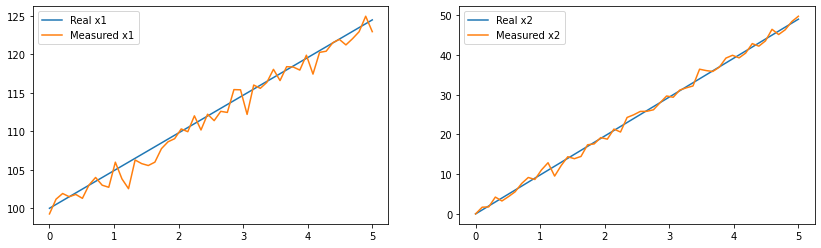

In [28]:
#Process noise
sigma_x1 = 1 
sigma_x2 = 1 
sigma_v1 = 1 
sigma_v2 = 1

#Measurement Noise
sigma_mx1 = 1
sigma_mx2 = 1

#Generate the data: assume constant velocity
N_steps = 50 
dt = 0.1 #s
t = np.linspace(0, N_steps*dt, N_steps)

v1_true = np.ones(N_steps)*5 #m/s
v2_true = np.ones(N_steps)*10 #m/s

x1_0 = 100 #m
x2_0 = 0 #m

x1_true = [x1_0 + v*dt*i for i, v in enumerate(v1_true)]
x2_true = [x2_0 + v*dt*i for i, v in enumerate(v2_true)] 

x1_meas = [x+np.random.normal(0, sigma_x1) for x in x1_true]
x2_meas = [x+np.random.normal(0, sigma_x2) for x in x2_true]

fig, ax = plt.subplots(1, 2)
ax[0].plot(t, x1_true, label='Real x1')
ax[0].plot(t, x1_meas, label='Measured x1')
ax[0].legend() 

ax[1].plot(t, x2_true, label='Real x2')
ax[1].plot(t, x2_meas, label='Measured x2')
ax[1].legend() 

fig.set_figwidth(14)

plt.show()

In [21]:
F = np.matrix([[1,0,dt,0],[0,1,0,dt],[0,0,0,0],[0,0,0,0]]) #State transition matrix 
Q = np.matrix([[sigma_x1**2,0,0,0], [0,sigma_x2**2,0,0],[0,0,sigma_v1**2,0],[0,0,0,sigma_v2**2]]) #Process noise uncertainty
H = np.matrix([[1,0,0,0],[0,1,0,0]]) #Observation Matrix
R = np.matrix([[sigma_mx1**2,0],[0,sigma_mx2**2]]) #Measurement Uncertainty
Kn = lambda P: np.matmul(np.matmul([P, H.T]), (np.matmul(np.matmul(H, P),H.T)+R)**-1) #Kalman Gain

In [ ]:
#Process: Initialize -> <Measure - Update - Predict> - loop

#Initialize: 
x1_0_guess = 10 #initial guessing values
x2_0_guess = 10 #initial guessing values
v1_0_guess = 10 
v2_0_guess = 10

sigma_x1_init = 100
sigma_x2_init = 100
sigma_v1_init = 100
sigma_v2_init = 100

Q_init = np.matrix([[sigma_x1_init**2,0,0,0], [0,sigma_x2_init**2,0,0],[0,0,sigma_v1_init**2,0],[0,0,0,sigma_v2_init**2]])

x_est = [[x1_0_guess, x2_0_guess]]
